In [2]:
from tqdm import tqdm
import numpy as np
from scipy.stats import bernoulli
import matplotlib.pyplot as plt

###SCM of the Rehab DTR under policy intervention

In [4]:
# global policy mapping tensors

NO_OF_POLICIES = (2**2) * (3**(4))

b_tensor = np.array([[0,0],
                     [0,1],
                     [1,0],
                     [1,1]])

d_tensor = np.zeros((81,2,2))
for pol in range(81):
  temp = pol
  digits = np.zeros((4,))
  for i in range(4):
    digits[3-i] = temp%3
    temp = int(temp/3)
  digits = np.reshape(digits,newshape=(2,2))
  d_tensor[pol] = digits

# global transition probabilities

f_tensor1 = np.array([[0.5011, 0.7787, 0.755],
                       [0.5602, 0.3759, 0.6166]])

f_tensor2 = np.array([[0.5315, 0.3952, 0.5807],
                       [0.4102, 0.685, 0.8256]])


def rehab_dtr1(pi = None):
  '''
  Runs an instance of the cancer DTR, under intervention using a policy pi
  SCM for first half of instances

  INPUT
  pi (int, 0-323): the policy index of the intervention

  OUTPUT
  a (int, 0-1): value of A for one instance under pi
  b (int, 0-1): value of B for one instance under pi
  c (int, 0-1): value of C for one instance under pi
  d (int, 0-2): value of D for one instance under pi
  e (int, 0-1): value of F for one instance under pi
  f (int, 0-1): value of F for one instance under pi  
  '''

  if pi not in np.arange(NO_OF_POLICIES):
    print("ERROR: pi should be an integer from 0-323")
    return
  
  # getting a
  a = bernoulli.rvs(p=0.5621)

  # mapping pi to get b
  pi_b = int(pi/81)
  b = b_tensor[pi_b][a]

  # getting c
  if a == 0:
    if b == 0:
      c = bernoulli.rvs(p=0.199)
    else:
      c = bernoulli.rvs(p=0.6863)
  else:
    if b == 0:
      c = bernoulli.rvs(p=0.3362)
    else:
      c = bernoulli.rvs(p=0.8121)
  
  # getting e
  if b == 0:
    e = bernoulli.rvs(p=0.18)
  else:
    e = bernoulli.rvs(p=0.8357)

  # mapping pi to get d
  pi_d = pi%81
  d = d_tensor[pi_d][c][e]
  d = int(d)

  # getting f
  f = bernoulli.rvs(p = f_tensor1[b][d])

  return a,b,c,d,e,f


def rehab_dtr2(pi = None):
  '''
  Runs an instance of the cancer DTR, under intervention using a policy pi
  SCM for second half of instances

  INPUT
  pi (int, 0-323): the policy index of the intervention

  OUTPUT
  a (int, 0-1): value of A for one instance under pi
  b (int, 0-1): value of B for one instance under pi
  c (int, 0-1): value of C for one instance under pi
  d (int, 0-2): value of D for one instance under pi
  e (int, 0-1): value of F for one instance under pi
  f (int, 0-1): value of F for one instance under pi  
  '''

  if pi not in np.arange(NO_OF_POLICIES):
    print("ERROR: pi should be an integer from 0-323")
    return
  
  # getting a
  a = bernoulli.rvs(p=0.2659)

  # mapping pi to get b
  pi_b = int(pi/81)
  b = b_tensor[pi_b][a]

  # getting c
  if a == 0:
    if b == 0:
      c = bernoulli.rvs(p=0.5643)
    else:
      c = bernoulli.rvs(p=0.2397)
  else:
    if b == 0:
      c = bernoulli.rvs(p=0.7622)
    else:
      c = bernoulli.rvs(p=0.4965)
  
  # getting e
  if b == 0:
    e = bernoulli.rvs(p=0.7304)
  else:
    e = bernoulli.rvs(p=0.3135)

  # mapping pi to get d
  pi_d = pi%81
  d = d_tensor[pi_d][c][e]
  d = int(d)

  # getting f
  f = bernoulli.rvs(p = f_tensor2[b][d])

  return a,b,c,d,e,f

In [7]:
(f_tensor1+f_tensor2)/2

array([[0.5163 , 0.58695, 0.66785],
       [0.4852 , 0.53045, 0.7211 ]])

### Naive EXP3 Algorithm

In [34]:
def naive_exp3(T = 500, eta = None):
  '''
  Plays Naive EXP3 for T episodes, with 100 overall runs

  INPUT:
  T (int, >=500): number of episodes; default 500
  eta (float, > 0): learning rate; default 1/T

  OUTPUT:
  regret: array of reget every 500 episodes, averaged over 100 runs
  cumulative_regret: array of cumulative regret every 500 episodes, avg. over 100 runs
  reward: array of reward every 500 episodes, avg. over 100 runs
  '''
 
  # initializations

  if T < 500:
    print("ERROR: T needs to be at least 500")
    return
  if eta == None:
    eta = 1/T
  if eta <= 0.0:
    print("ERROR: eta needs to be > 0.0") 
  RUNS = 50
  step = 500
  data_points = int(T/step)+1
  regret = np.zeros((RUNS,data_points))
  cumulative_regret = np.zeros((RUNS,data_points))
  reward = np.zeros((RUNS,data_points))

  # main loop
   
  for run in tqdm(range(RUNS)):
    W = np.ones((NO_OF_POLICIES,))
    track_regret = 0

    for t in range(T):
      # normalize weights
      P = W/W.sum()

      # sample a policy
      pi = np.random.multinomial(1,P) @ np.arange(NO_OF_POLICIES)

      # play policy arm on DTR
      if t < int(T/2):
        _,_,_,_,_,f = rehab_dtr1(pi)
      else:
        _,_,_,_,_,f = rehab_dtr2(pi)

      # weight updates
      loss = 1-f
      loss_unbiased = loss/P[pi]
      W[pi] = W[pi]*np.exp(-eta*loss_unbiased)

      # tracking reward
      track_regret = track_regret + 0.7211 - f
      if int(t%step) == 0:
        regret[run][int(t/step)]             = 0.7211 - f
        cumulative_regret[run][int(t/step)]  = track_regret
        reward[run][int(t/step)]             = f

  return regret, cumulative_regret, reward

In [35]:
regret1, cumulative_regret1, reward1 = naive_exp3(T=10001)

100%|██████████| 50/50 [02:08<00:00,  2.57s/it]


### CausalEXP3 algorithm

In [36]:
# estimate update function

def update(a,b,c,e,t):
  global hat_a
  global hat_b
  global hat_a_b
  global hat_c
  global hat_e
  hat_a[a] += 1
  hat_a_b[a][b] += 1
  hat_b[0][b] += 1
  hat_c[a][b][c] += 1
  hat_e[b][e] += 1

  global p_hat_a
  global p_hat_c
  global p_hat_e
  p_hat_c = hat_c
  
  p_hat_a = hat_a/(t+1) # update P_hat(a)
  
  for a in [0,1]:
    for b in [0,1]:
      for c in [0,1]:
        p_hat_c[a][b][c] = hat_c[a][b][c]/max(1,hat_a_b[a][b]) # update P_hat(c|do(b),a)

  temp = hat_b.T == 0 
  temp = temp + hat_b.T # max{1,#b}
  p_hat_e = hat_e/temp # update P_hat(e|do(b))


def estimate_loss(pi,t,T):
  sum = 0
  for a in [0,1]: # loop over a
    pi_b = int(pi/81)
    b = b_tensor[pi_b][a] # get b from a
    for c in [0,1]: # loop over c
      for e in [0,1]: # loop over e
        pi_d = pi%81
        d = d_tensor[pi_d][c][e]
        d = int(d) # get d from c,e

        if t < T/2:
          factor = f_tensor1[b][d]
        else:
          factor = f_tensor2[b][d]
        factor *= p_hat_a[a]
        factor *= p_hat_c[a][b][c]
        factor *= p_hat_e[b][e]
        sum += factor

  return sum

In [37]:
def causalexp3(T = 500, eta = None):
  '''
  Plays CausalEXP3 for T episodes, with 100 overall runs

  INPUT:
  T (int, >=500): number of episodes; default 500
  eta (float, > 0): learning rate; default 1/T

  OUTPUT:
  regret: array of reget every 500 episodes, averaged over 100 runs
  cumulative_regret: array of cumulative regret every 500 episodes, avg. over 100 runs
  reward: array of reward every 500 episodes, avg. over 100 runs
  '''
 
  # initializations

  if T < 500:
    print("ERROR: T needs to be at least 500")
    return
  if eta == None:
    eta = 1/T
  if eta <= 0.0:
    print("ERROR: eta needs to be > 0.0") 
  RUNS = 50
  step = 500
  data_points = int(T/step)+1
  regret = np.zeros((RUNS,data_points))
  cumulative_regret = np.zeros((RUNS,data_points))
  reward = np.zeros((RUNS,data_points))

  # main loop
   
  for run in tqdm(range(RUNS)):
    W = np.ones((NO_OF_POLICIES,))
    track_regret = 0
    global hat_a
    global hat_b
    global hat_a_b
    global hat_c
    global p_hat_a
    global p_hat_c
    global hat_e
    global p_hat_e
    hat_a = np.array([0,0])
    hat_b = np.array([[0,0]])
    hat_a_b = np.array([[0,0],
                        [0,0]])
    hat_c = np.array( [[[0,0],[0,0]],
                       [[0,0],[0,0]]] )
    hat_e = np.array([[0,0],
                      [0,0]])


    for t in range(T):
      # normalize weights
      P = W/W.sum()

      # sample a policy
      pi_t = np.random.multinomial(1,P) @ np.arange(NO_OF_POLICIES)

      # play policy arm on DTR
      if t < int(T/2):
        a,b,c,d,e,f = rehab_dtr1(pi_t)
      else:
        a,b,c,d,e,f = rehab_dtr2(pi_t)

      # update estimates
      update(a=a,b=b,c=c,e=e,t=t)

      # weight updates
      for pi in range(NO_OF_POLICIES):
        loss = estimate_loss(pi,t,T)
        loss = 1-loss
        loss_unbiased = loss/P[pi]
        W[pi] = W[pi]*np.exp(-eta*loss_unbiased)

      # tracking reward
      track_regret = track_regret + 0.7211 - f
      # print(t)
      if int(t%step) == 0:
        regret[run][int(t/step)]             = 0.7211 - f
        cumulative_regret[run][int(t/step)]  = track_regret
        reward[run][int(t/step)]             = f

  return regret, cumulative_regret, reward

In [38]:
regret2, cumulative_regret2, reward2 = causalexp3(T=10001)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in double_scalars
100%|██████████| 50/50 [1:14:41<00:00, 89.63s/it]


## Plots

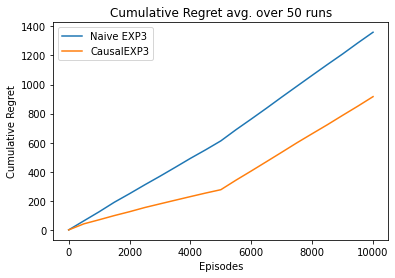

In [46]:
# Cumulative Regret

T = 10001

# line 1 points
x1 = np.arange(T, step=500)
y1 = np.average(cumulative_regret1,axis=0)
# plotting the line 1 points
plt.plot(x1, y1, label = "Naive EXP3")
 
# line 2 points
x2 = x1
y2 = np.average(cumulative_regret2,axis=0)
# plotting the line 2 points
plt.plot(x2, y2, label = "CausalEXP3")
 
# naming the x axis
plt.xlabel('Episodes')
# naming the y axis
plt.ylabel('Cumulative Regret')
# giving a title to my graph
plt.title('Cumulative Regret avg. over 50 runs')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

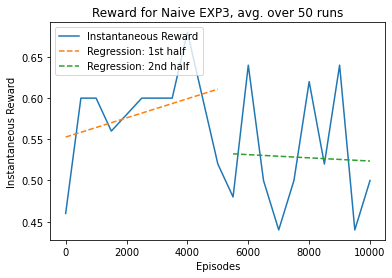

In [47]:
# Instantaneous Reward for Naive EXP3

T = 10001

# line 1 points
x1 = np.arange(T, step=500)
y1 = np.average(reward1,axis=0)
# plotting the line 1 points
plt.plot(x1, y1, label = "Instantaneous Reward")
# plt.scatter(x1, y1)
halfway = int(T/1000) + 1
x1_first = x1[:halfway]
x1_second = x1[halfway:]
y1_first = y1[:halfway]
y1_second = y1[halfway:]
m, b = np.polyfit(x1_first, y1_first, 1)
plt.plot(x1_first, m*x1_first+b, label = "Regression: 1st half", linestyle='dashed')
m, b = np.polyfit(x1_second, y1_second, 1)
plt.plot(x1_second, m*x1_second+b, label = "Regression: 2nd half", linestyle='dashed')


# naming the x axis
plt.xlabel('Episodes')
# naming the y axis
plt.ylabel('Instantaneous Reward')
# giving a title to my graph
plt.title('Reward for Naive EXP3, avg. over 50 runs')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

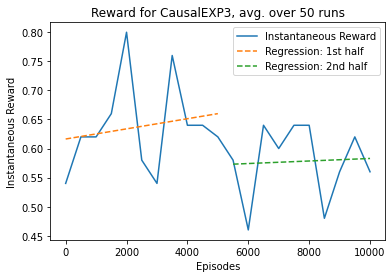

In [45]:
# Instantaneous Reward for CausalEXP3

T = 10001

# line 1 points
x1 = np.arange(T, step=500)
y1 = np.average(reward2,axis=0)
# plotting the line 1 points
plt.plot(x1, y1, label = "Instantaneous Reward")
# plt.scatter(x1, y1)
halfway = int(T/1000) + 1
x1_first = x1[:halfway]
x1_second = x1[halfway:]
y1_first = y1[:halfway]
y1_second = y1[halfway:]
m, b = np.polyfit(x1_first, y1_first, 1)
plt.plot(x1_first, m*x1_first+b, label = "Regression: 1st half", linestyle='dashed')
m, b = np.polyfit(x1_second, y1_second, 1)
plt.plot(x1_second, m*x1_second+b, label = "Regression: 2nd half", linestyle='dashed')


# naming the x axis
plt.xlabel('Episodes')
# naming the y axis
plt.ylabel('Instantaneous Reward')
# giving a title to my graph
plt.title('Reward for CausalEXP3, avg. over 50 runs')
 
# show a legend on the plot
plt.legend()
 
# function to show the plot
plt.show()

## Probability Generation

In [13]:
vals = 0.8*np.random.random_sample(23) + 0.1
for i in range(23):
  num = round(vals[i],4)
  vals[i] = num

vals

array([0.7341, 0.7231, 0.1903, 0.4357, 0.2378, 0.7603, 0.5035, 0.7008,
       0.6466, 0.6593, 0.4147, 0.6767, 0.1747, 0.2991, 0.8065, 0.2696,
       0.6865, 0.5315, 0.4102, 0.3952, 0.685 , 0.5807, 0.8256])

In [14]:
1-0.7341

0.2659